In [15]:
import torch
from torch import nn
import torch.nn.functional as F
import torchvision
from torchvision import transforms
from tqdm import tqdm
import matplotlib.pyplot as plt

In [16]:
preprocess = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.Resize((224,224)),
    transforms.ToTensor()
])

In [17]:
dataset = torchvision.datasets.ImageFolder('D://research/pytorch-implementations/data/animal10/', transform=preprocess)

In [18]:
batch_size = 16

In [19]:
loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True, drop_last=True)

In [20]:
class ConvBlock(nn.Module):
    def __init__(self, input_channel: int, output_channel: int, kernel_size: int = 3, stride: int = 1, padding: int = 0, enable_relu: bool = True):
        super(ConvBlock, self).__init__()
        self.enable_relu = enable_relu
        self.block = nn.Sequential(
            nn.Conv2d(input_channel, output_channel, kernel_size, stride=stride, padding=padding, bias=False),
            nn.BatchNorm2d(output_channel),
        )
        
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        y = self.block(x)
        
        return F.relu(y, inplace=True) if self.enable_relu else y

In [21]:
class ResBlock(nn.Module):
    
    def __init__(self, input_channel: int, block_base_channel: int):
        super(ResBlock, self).__init__()
        equal_channel_size = input_channel == block_base_channel * 4
    
        self.block = nn.Sequential(
            ConvBlock(input_channel, block_base_channel, 1),
            ConvBlock(block_base_channel, block_base_channel, 3, padding = 1),
            ConvBlock(block_base_channel, block_base_channel * 4, 1)
        )
        
        self.downsample = nn.Identity() if equal_channel_size else nn.Sequential(
            ConvBlock(input_channel, block_base_channel * 4, 1)
        )
        
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return self.block(x) + self.downsample(x)

In [22]:
class ResNet50(nn.Module):
    
    def __init__(self):
        super(ResNet50, self).__init__()
        self.foot = nn.Sequential(
            nn.Conv2d(3, 64, 7, stride=2, padding = 3, bias=False),
            nn.BatchNorm2d(64),
            nn.MaxPool2d(3, stride=2)
        )
        self.block1 = nn.Sequential(
            ResBlock(64, 64),
            ResBlock(256, 64),
            ResBlock(256, 64)
        )
        self.block2 = nn.Sequential(
            ResBlock(256,128),
            ResBlock(512,128),
            ResBlock(512,128),
            ResBlock(512,128),
            nn.MaxPool2d(2,2)
        )
        self.block3 = nn.Sequential(
            ResBlock(512,256),
            ResBlock(1024,256),
            ResBlock(1024,256),
            ResBlock(1024,256),
            ResBlock(1024,256),
            ResBlock(1024,256),
            nn.MaxPool2d(2,2)
        )
        self.block4 = nn.Sequential(
            ResBlock(1024,512),
            ResBlock(2048,512),
            ResBlock(2048,512),
            nn.AdaptiveAvgPool2d((1,1))
        )
        self.fc = nn.Sequential(
            nn.Linear(2048,10)
        )

        
    def forward(self, x):
        tmp = self.foot(x)
        tmp = self.block1(tmp)
        tmp = self.block2(tmp)
        tmp = self.block3(tmp)
        tmp = self.block4(tmp)
        tmp = torch.flatten(tmp,start_dim=1)
        tmp = self.fc(tmp)

        return tmp

In [23]:
model = ResNet50().cuda()

In [24]:
model.eval()
model(torch.randn(batch_size, 3, 224, 224).cuda()).shape

torch.Size([16, 10])

In [25]:
criterion = nn.CrossEntropyLoss()
optim = torch.optim.Adam(model.parameters())

In [26]:
epoches = 3
acc_iters = 64/batch_size

In [31]:
model.train()
training_loss = []
for e in range(epoches):
    running_loss = 0.0
    acc_iter = 0
    
    for img, label in tqdm(loader):
        optim.zero_grad()

        img = img.cuda()
        label = label.cuda()
        
        output = model(img)
        loss = criterion(output,label)
        loss /= acc_iters

        running_loss += loss.item()
        acc_iter += 1

        if acc_iter % acc_iters == 0:
            loss.backward()
            optim.step()

    training_loss.append(running_loss/len(dataset))
    
    print(f'epoch {e+1}: {training_loss[e]}')

100%|██████████| 1636/1636 [02:46<00:00,  9.85it/s]


epoch 1: 0.031197044215895756


100%|██████████| 1636/1636 [02:44<00:00,  9.94it/s]


epoch 2: 0.029328144801310064


100%|██████████| 1636/1636 [02:43<00:00, 10.03it/s]

epoch 3: 0.028946732354767933


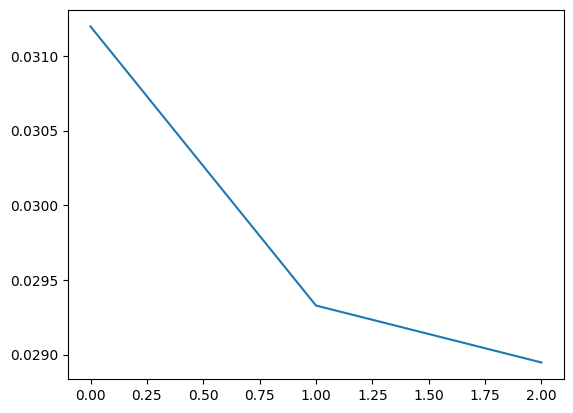

In [32]:
plt.plot(training_loss)

In [33]:
model.eval()
with torch.no_grad():
    running_hit = 0.0

    for img, label in tqdm(loader):
        img = img.cuda()
        
        output = model(img)
        output = output.detach().cpu()
        img = img.detach().cpu()

        output = output.argmax(dim=1)
        acc = (label == output).sum()
        running_hit += acc.item()

    print(running_hit/len(dataset))

100%|██████████| 1636/1636 [02:25<00:00, 11.28it/s]

0.37560640207800144


In [34]:
torch.save(model,'resnet.pth')

In [38]:
import os
os.stat('resnet.pth').st_size / 1024**2

90.10343742370605

In [12]:
model = torch.load('resnet.pth')

IncompatibleKeys(missing_keys=[], unexpected_keys=[])

In [22]:
# Netron 檢查
torch.onnx.export(model.cpu(),torch.randn(1,3,224,224),'a.onnx')